In [1]:
# 1) Install PyTorch CPU wheels from the PyTorch index ONLY for torch/vision/audio
!pip install -U --no-cache-dir \
  torch==2.5.1+cpu torchvision==0.20.1+cpu torchaudio==2.5.1+cpu \
  --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
# 0) Remove troublemakers that pin NumPy>=2
!pip uninstall -y numba opencv-python opencv-contrib-python opencv-python-headless transformers

# 1) Core numerical stack (NumPy 1.26.x)
!pip install -U --no-cache-dir numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.4 scikit-learn==1.5.1 tqdm==4.66.5 nltk==3.9.1

# 2) PyTorch CPU wheels (from PyTorch index only for these three)
!pip install -U --no-cache-dir torch==2.5.1+cpu torchvision==0.20.1+cpu torchaudio==2.5.1+cpu \
  --index-url https://download.pytorch.org/whl/cpu

# 3) HF + RAG deps (from PyPI)
!pip install -U --no-cache-dir \
  transformers==4.41.2 accelerate==0.31.0 huggingface_hub==0.23.5 \
  tokenizers==0.19.1 safetensors==0.4.3 \
  datasets==2.19.0 sentence-transformers==2.6.1 \
  faiss-cpu==1.8.0 evaluate==0.4.2


Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 154.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.0 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.23.5 which is incompatible.


In [3]:
import numpy, transformers, torch, sklearn, datasets, pandas
print("NumPy:", numpy.__version__)               # 2.1.3
print("Transformers:", transformers.__version__) # 4.45.0
print("PyTorch:", torch.__version__, "CUDA?", torch.cuda.is_available())
print("sklearn:", sklearn.__version__)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
print("HF import OK ✅")


NumPy: 1.26.4
Transformers: 4.41.2
PyTorch: 2.5.1+cpu CUDA? False
sklearn: 1.5.1
HF import OK ✅


In [4]:
#@title 📚 Build a mini Knowledge Base from SQuAD contexts
from datasets import load_dataset
import pandas as pd

# SQuAD v1.1 train set — contexts as KB, questions as queries
ds = load_dataset("squad", split="train")
df = ds.to_pandas()[["context", "question", "answers"]]

# Deduplicate contexts to make a KB; keep top-N to fit runtime
KB_MAX_DOCS = 20000  # increase if you have GPU/Colab Pro
kb_df = pd.DataFrame({"doc": df["context"].drop_duplicates().head(KB_MAX_DOCS)}).reset_index(drop=True)

print("KB docs:", len(kb_df))
kb_df.head(3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

KB docs: 18891


,doc
0,"Architecturally, the school has a Catholic cha..."
1,"As at most other universities, Notre Dame's st..."
2,The university is the major seat of the Congre...


In [5]:
import torch

# Choose GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [6]:
from sentence_transformers import SentenceTransformer
import faiss, numpy as np

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # fast, decent quality
embedder = SentenceTransformer(EMB_MODEL, device=device)

BATCH = 512
embs = []
for i in range(0, len(kb_df), BATCH):
    embs.append(embedder.encode(
        kb_df["doc"].iloc[i:i+BATCH].tolist(),
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True
    ))
kb_emb = np.vstack(embs).astype("float32")

index = faiss.IndexFlatIP(kb_emb.shape[1])
index.add(kb_emb)
print("FAISS index size:", index.ntotal)

def retrieve(query, k=5):
    q_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype("float32")
    D, I = index.search(q_emb, k)
    ctxs = [kb_df["doc"].iloc[j] for j in I[0]]
    return ctxs, D[0].tolist(), I[0].tolist()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

FAISS index size: 18891


In [7]:
#@title 🧠 Generator setup (FLAN-T5) with output scores for uncertainty
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

GEN_MODEL = "google/flan-t5-base"  # switch to "large" if you have GPU headroom
tokenizer = AutoTokenizer.from_pretrained(GEN_MODEL)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(GEN_MODEL).to(device)

def rag_prompt(question, passages, max_ctx=2):
    passages = passages[:max_ctx]
    ctx = "\n\n".join([f"[Source {i+1}] {p}" for i, p in enumerate(passages)])
    return (
        "You are a helpful assistant that MUST answer using only the sources.\n"
        "If the answer isn't in the sources, say you don't know.\n\n"
        f"Sources:\n{ctx}\n\nQuestion: {question}\nAnswer:"
    )

@torch.no_grad()
def generate_answer(prompt, temperature=0.7, top_p=0.9, max_new_tokens=64, return_scores=True):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = gen_model.generate(
        **inputs,
        do_sample=True, temperature=temperature, top_p=top_p,
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        output_scores=return_scores,
        return_dict_in_generate=True
    )
    text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True).strip()
    # Token-level entropy proxy for uncertainty
    token_scores = None
    if return_scores and outputs.scores:
        import torch.nn.functional as F
        entropies = []
        for logits in outputs.scores:
            probs = F.softmax(logits, dim=-1)
            ent = -(probs * (probs.clamp_min(1e-9)).log()).sum(-1).mean().item()
            entropies.append(ent)
        token_scores = {
            "mean_entropy": float(np.mean(entropies)),
            "std_entropy": float(np.std(entropies)),
            "n_steps": len(entropies)
        }
    return text, token_scores


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [8]:
#@title ✅ NLI-based entailment scoring (does answer follow from sources?)
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

NLI_MODEL = "roberta-large-mnli"
nli_tok = AutoTokenizer.from_pretrained(NLI_MODEL)
nli_model = AutoModelForSequenceClassification.from_pretrained(NLI_MODEL).to(device).eval()

label2id = {0:"contradiction", 1:"neutral", 2:"entailment"}
id2label = {v:k for k,v in label2id.items()}

@torch.no_grad()
def nli_entailment_score(premise, hypothesis):
    inputs = nli_tok(premise, hypothesis, return_tensors="pt", truncation=True, max_length=512).to(device)
    logits = nli_model(**inputs).logits[0]
    probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
    return float(probs[2]), {"contradiction": float(probs[0]), "neutral": float(probs[1]), "entailment": float(probs[2])}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
#@title 🔁 Self-consistency: sample multiple answers & vote
from collections import Counter
import numpy as np

def self_consistency(prompt, samples=5, temperature=0.9):
    answers = []
    ents = []
    for _ in range(samples):
        ans, token_scores = generate_answer(prompt, temperature=temperature, top_p=0.95)
        answers.append(ans)
        ents.append(token_scores["mean_entropy"] if token_scores else None)
    counts = Counter([a.strip().lower() for a in answers])
    top_ans, top_freq = counts.most_common(1)[0]
    diversity = len(counts)
    return {
        "answers": answers,
        "mode_answer": top_ans,
        "mode_freq": top_freq,
        "diversity": diversity,
        "entropy_mean": float(np.nanmean(ents))
    }


In [10]:
#@title 🚨 Hallucination Firewall (multi-signal decision)
def firewall_decision(question, passages, answer, nli_thresh=0.65, entropy_thresh=8.0):
    premise = "\n\n".join(passages[:2])
    entail_p, dist = nli_entailment_score(premise, answer)
    flagged = entail_p < nli_thresh  # add entropy-based rule if desired
    return {
        "entailment_p": entail_p,
        "nli_dist": dist,
        "flagged": bool(flagged)
    }


In [11]:
#@title 🧪 Causal interventions on retrieval
import random

def intervene_random_docs(k=2):
    # Sample random docs from KB
    idx = np.random.choice(len(kb_df), size=k, replace=False)
    return [kb_df["doc"].iloc[i] for i in idx]

def intervene_drop_top(ctxs, drop=1):
    return ctxs[drop:] if len(ctxs) > drop else ctxs

def intervene_shuffle(ctxs):
    cc = ctxs[:]
    random.shuffle(cc)
    return cc


In [12]:
#@title ▶️ Quick Demo
examples = [
    "Who wrote the novel The Metamorphosis?",
    "What is the capital of France?",
    "Which organ pumps blood throughout the human body?",
]

for q in examples:
    ctxs, D, I = retrieve(q, k=5)
    prompt = rag_prompt(q, ctxs, max_ctx=2)
    ans, token_scores = generate_answer(prompt, temperature=0.7)
    fw = firewall_decision(q, ctxs, ans)
    print("\nQ:", q)
    print("A:", ans)
    print("entail_p:", fw["entailment_p"], "flagged:", fw["flagged"], "entropy_mean:", token_scores["mean_entropy"] if token_scores else None)


Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors



Q: Who wrote the novel The Metamorphosis?
A: Ibn Tufail.
entail_p: 0.6225606799125671 flagged: True entropy_mean: 0.1487958166334364

Q: What is the capital of France?
A: Strasbourg
entail_p: 0.3237783908843994 flagged: True entropy_mean: 0.6232211887836456

Q: Which organ pumps blood throughout the human body?
A: the coelom
entail_p: 0.004148848820477724 flagged: True entropy_mean: 0.3684172374861581


In [13]:
# 🔧 Bootstrap missing globals after a restart
import random, numpy as np, torch

# Define SEED (and re-seed everything)
SEED = 42
random.seed(SEED); np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Make sure `device` exists (some later cells use it)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("SEED =", SEED, "| device:", device)


SEED = 42 | device: cpu


In [14]:
#@title 📈 Evaluation on a SQuAD subset
from tqdm import tqdm
import pandas as pd
import numpy as np

N = 120  # increase for deeper runs
subset = df.sample(N, random_state=SEED).reset_index(drop=True)

records = []
for i, row in tqdm(subset.iterrows(), total=len(subset)):
    q = row["question"]
    gold = row["answers"]["text"][0] if len(row["answers"]["text"]) else ""
    ctxs, D, I = retrieve(q, k=5)
    prompt = rag_prompt(q, ctxs, max_ctx=2)
    sc = self_consistency(prompt, samples=5, temperature=0.9)
    ans = sc["mode_answer"]
    fw = firewall_decision(q, ctxs, ans)
    # Simple exact-match proxy (strict) for reference
    em = int(ans.strip().lower() == gold.strip().lower())
    records.append({
        "q": q,
        "gold": gold,
        "answer": ans,
        "entail_p": fw["entailment_p"],
        "flagged": int(fw["flagged"]),
        "self_consistency_diversity": sc["diversity"],
        "self_consistency_mode_freq": sc["mode_freq"],
        "entropy_mean": sc["entropy_mean"],
        "retr_idxs": I
    })

eval_df = pd.DataFrame(records)
print(eval_df.head())
eval_df.to_csv("safe_rag_eval.csv", index=False)
print("Saved -> safe_rag_eval.csv")


100%|██████████| 120/120 [27:10<00:00, 13.59s/it]

                                                   q  \
0         What year was the Banská Akadémia founded?   
1  What is another speed that can also be reporte...   
2  Where were the use of advanced materials and t...   
3           Who is elected every even numbered year?   
4  What was the purpose of top secret ICBM commit...   

                                                gold  \
0                                               1735   
1                                    SOS-based speed   
2                       Sumerian temples and palaces   
3                                              mayor   
4  decide on the feasibility of building an ICBM ...   

                                              answer  entail_p  flagged  \
0                                               1735  0.435925        1   
1                                                sos  0.174682        1   
2                                       clay tablets  0.364363        1   
3                         

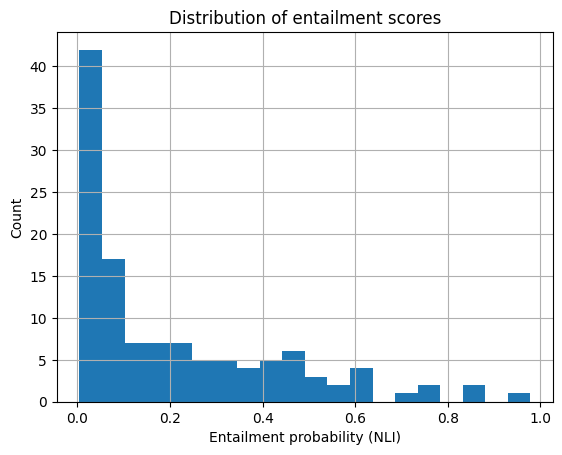

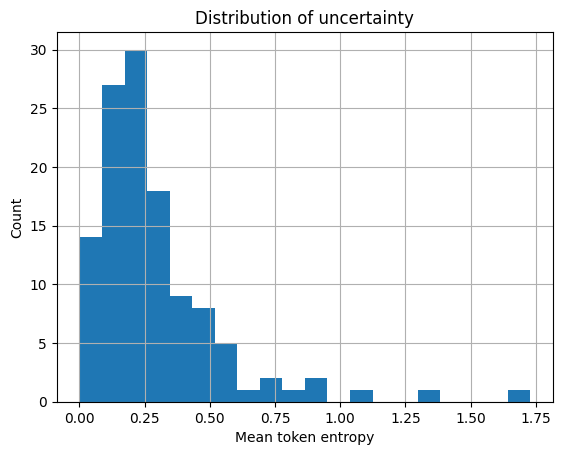

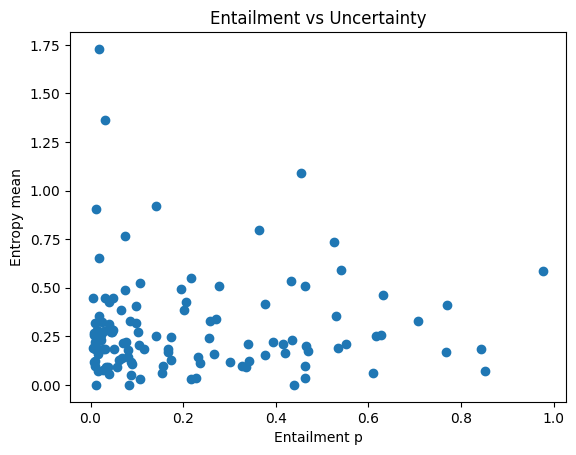

In [15]:
#@title 📊 Visualize signals
import matplotlib.pyplot as plt

plt.figure()
eval_df["entail_p"].hist(bins=20)
plt.xlabel("Entailment probability (NLI)")
plt.ylabel("Count")
plt.title("Distribution of entailment scores")
plt.show()

plt.figure()
eval_df["entropy_mean"].hist(bins=20)
plt.xlabel("Mean token entropy")
plt.ylabel("Count")
plt.title("Distribution of uncertainty")
plt.show()

plt.figure()
plt.scatter(eval_df["entail_p"], eval_df["entropy_mean"])
plt.xlabel("Entailment p")
plt.ylabel("Entropy mean")
plt.title("Entailment vs Uncertainty")
plt.show()


In [16]:
#@title 🔬 Causal Ablation: drop top retrieval vs random vs shuffled
import pandas as pd

def run_ablation(qs, k=5):
    out = []
    for q in qs:
        base_ctxs, _, _ = retrieve(q, k=k)
        for name, mod in [
            ("base", lambda x: x),
            ("drop_top1", lambda x: intervene_drop_top(x, 1)),
            ("random_docs", lambda x: intervene_random_docs(k=2)),
            ("shuffled", intervene_shuffle),
        ]:
            ctxs = mod(base_ctxs)
            prompt = rag_prompt(q, ctxs, max_ctx=2)
            ans, token_scores = generate_answer(prompt, temperature=0.7)
            fw = firewall_decision(q, ctxs, ans)
            out.append({
                "q": q, "variant": name, "answer": ans,
                "entail_p": fw["entailment_p"],
                "flagged": int(fw["flagged"]),
                "entropy_mean": token_scores["mean_entropy"] if token_scores else None
            })
    return pd.DataFrame(out)

ablation_df = run_ablation(examples, k=5)
ablation_df


,q,variant,answer,entail_p,flagged,entropy_mean
0,Who wrote the novel The Metamorphosis?,base,Ibn Tufail,0.622187,1,0.167395
1,Who wrote the novel The Metamorphosis?,drop_top1,Ibn Tufail,0.232002,1,0.227376
2,Who wrote the novel The Metamorphosis?,random_docs,Walter Matthau,0.124478,1,0.761165
3,Who wrote the novel The Metamorphosis?,shuffled,Robert Boyle.,0.594437,1,0.126875
4,What is the capital of France?,base,Paris,0.181346,1,0.507887
5,What is the capital of France?,drop_top1,Strasbourg,0.329648,1,0.269213
6,What is the capital of France?,random_docs,Paris,0.208191,1,0.636476
7,What is the capital of France?,shuffled,Boulogne-Billancourt.,0.471789,1,0.124581
8,Which organ pumps blood throughout the human b...,base,the coelom,0.004149,1,0.368417
9,Which organ pumps blood throughout the human b...,drop_top1,arterioles,0.020761,1,0.068221


In [17]:
#@title 💾 Save artifacts
eval_df.to_csv("safe_rag_eval.csv", index=False)
try:
    ablation_df.to_csv("safe_rag_ablation.csv", index=False)
except NameError:
    pass
print("Artifacts saved: safe_rag_eval.csv, safe_rag_ablation.csv (if ablation ran).")


Artifacts saved: safe_rag_eval.csv, safe_rag_ablation.csv (if ablation ran).


In [19]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
                   --to notebook --inplace SAFE-RAG.ipynb


[NbConvertApp] WARNING | pattern 'SAFE-RAG.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Ex

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose SAFE-RAG.ipynb from your computer
